<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/guinier_fsc_sharpen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

* Study the effect of masking and sharpening on the FSC. Build up ideas with the Guinier plot

# Resources
* Rosenthal, P. B., & Henderson, R. (2003). Optimal Determination of Particle Orientation, Absolute Hand, and Contrast Loss in Single-particle Electron Cryomicroscopy. Journal of Molecular Biology, 333(4), 721–745. http://doi.org/10.1016/j.jmb.2003.07.013
* Rohou, Alexis. (2021). Section 4.7: B factors and map sharpening in Glaeser, R. M., Nogales, E., & Chiu, W. (Eds.). (2021). Single-particle Cryo-EM of Biological Macromolecules. IOP Publishing. http://doi.org/10.1088/978-0-7503-3039-8

# Setup

In [1]:
!pip install pyfftw
!pip install mrcfile
import mrcfile

     |████████████████████████████████| 2.6MB 8.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 


In [ ]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/24d84e4f030861e6df60c4ab2ad17db491c60ad3/src/fourier.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/24d84e4f030861e6df60c4ab2ad17db491c60ad3/src/coords.py
import fourier, coords

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def doplt(arr): return(plt.imshow(arr,cmap='gray'))

# 3D map data
First let's load up the map 

In [ ]:
!wget https://github.com/geoffwoollard/learn_cryoem_math/raw/24d84e4f030861e6df60c4ab2ad17db491c60ad3/data/t20s_3d/J209/cryosparc_P9_J209_005_volume_map_half_A.mrc
!wget https://github.com/geoffwoollard/learn_cryoem_math/raw/24d84e4f030861e6df60c4ab2ad17db491c60ad3/data/t20s_3d/J209/cryosparc_P9_J209_005_volume_map_half_B.mrc
!wget https://github.com/geoffwoollard/learn_cryoem_math/raw/24d84e4f030861e6df60c4ab2ad17db491c60ad3/data/t20s_3d/J209/cryosparc_P9_J209_005_volume_map_sharp.mrc
!wget https://github.com/geoffwoollard/learn_cryoem_math/raw/24d84e4f030861e6df60c4ab2ad17db491c60ad3/data/t20s_3d/J209/cryosparc_P9_J209_005_volume_mask_refine.mrc



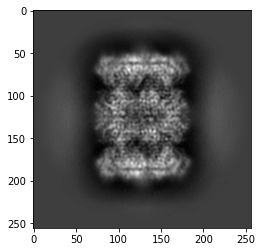

In [9]:
fname = 'cryosparc_P9_J209_005_volume_map_sharp.mrc'
def load_mrc(fname, only_map=True):
  map_mrc = mrcfile.open(fname)
  map_original = map_mrc.data
  N = map_original.shape[0]
  psize = map_mrc.voxel_size.item(0)[0]

  if only_map:
    return map_original 
  else:
    return map_original, psize, N
map_original, psize, N = load_mrc(fname, only_map=False)
doplt(map_original.sum(-1))

In [6]:
map_r = map_original.copy()
map_f = fourier.do_fft(map_r)

# Guinier plot
* Now let's compute the power in each Fourier shell
* Understanding how the y-axis on the Guinier plot is computed helps us understand the FSC.

### Fourier shell

In [7]:
def cmask_3d(index,radius,array,do_shell=False,shell_thickness=1):
  '''
  make a binary spherical shell mask (variable thickness). 
  '''
  a,b,c = index
  nx0,nx1,nx2 = array.shape
  x0,x1,x2 = np.ogrid[-a:nx0-a,-b:nx1-b,-c:nx1-c]
  r2 = x0*x0+x1*x1+x2*x2
  mask = r2 <= radius*radius
  if do_shell:
    mask_outer = mask
    mask_inner = r2 <= (radius-shell_thickness)*(radius-shell_thickness)
    mask = np.logical_xor(mask_outer,mask_inner)
  return(mask)

### What is a structure factor: complex amplitude and phase

The map in Fourier space has a complex numbers (two numbers) in each pixel.

In [11]:
radius = 1
shell_mask = cmask_3d(index=(N//2,N//2,N//2),radius=radius,array=np.ones_like(map_r), do_shell=True, shell_thickness=1).astype(np.bool)
map_f[shell_mask]

array([3.8334439 -0.39917557j, 3.0194061 -0.10156008j,
       4.22780186+0.21735201j, 4.22780186-0.21735201j,
       3.0194061 +0.10156008j, 3.8334439 +0.39917557j])

The Fourier pixels can also be expressed as a amplitude (magnitude) and phase (angle).

$$z = a + ib = Ae^{i\theta} = A[\cos(\theta) + i\sin(\theta)]$$
$$A = \sqrt{a^2 + b^2}$$
$$\theta = \arctan2(y,x)$$

We can compute the absolute by using `np.abs`

In [12]:
As = np.abs(map_f[shell_mask])
As

array([3.8541709 , 3.02111365, 4.23338523, 4.23338523, 3.02111365,
       3.8541709 ])

In [13]:
thetas = np.arctan2(map_f[shell_mask].imag,map_f[shell_mask].real)
thetas

array([-0.10375582, -0.03362311,  0.05136495, -0.05136495,  0.03362311,
        0.10375582])

In [14]:
np.allclose(As*np.exp(thetas*1j), map_f[shell_mask])

True

We can compute the (average) power in the shell by averaging the per pixel power in the shell. This gives us one data point in the Guinier plot

In [16]:
structure_factor = np.abs(map_f[shell_mask]).mean()


Let's do this over a bunch of fourier shells

In [17]:
shell_rads = np.arange(2,128,4)#[2,4,8,16,32,64,128]
structure_factors = np.zeros(len(shell_rads))
for idx, radius in enumerate(shell_rads):
  shell_mask = cmask_3d(index=(N//2,N//2,N//2),radius=radius,array=np.ones_like(map_r), do_shell=True, shell_thickness=1).astype(np.bool)
  structure_factors[idx] = np.abs(map_f[shell_mask]).mean()

Text(0.5, 0, 'Resolution^2')

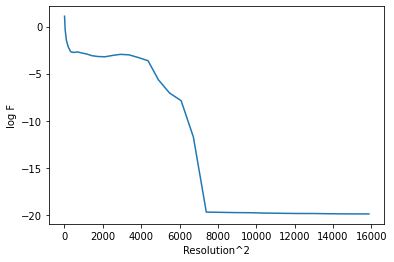

In [19]:
sr = pd.Series(np.log(structure_factors))
sr.index = shell_rads**2 # note the squared
sr.plot()

plt.ylabel('log F')
plt.xlabel('Resolution^2')

Note that the there is practically no power at high resolution. Likely our map has been low pass filtered. 

Note that the x-axis of the Guinier plot is resolution squared, not resolution like in the FSC.

# FSC
Now let's load the half maps
* we can compute the FSC using the same Fourier shells that go into the Guinier plot


## without masking

In [20]:
half_map_A  = load_mrc('cryosparc_P9_J209_005_volume_map_half_A.mrc', only_map=True)
half_map_B  = load_mrc('cryosparc_P9_J209_005_volume_map_half_B.mrc', only_map=True)

half_map_A_f = fourier.do_fft(half_map_A)
half_map_B_f = fourier.do_fft(half_map_B)

In [21]:
shell_rads = np.arange(2,128,4)

def complex_corr(arr_1,arr_2):
  return (arr_1*arr_2.conj()).sum()

def do_fsc(half_map_A_f,half_map_B_f,shell_rads):
  fscs = np.zeros(len(shell_rads),dtype=half_map_B_f.dtype)
  N = half_map_A_f.shape[0]
  for idx, radius in enumerate(shell_rads):
    shell_mask = cmask_3d(index=(N//2,N//2,N//2),radius=radius,array=np.ones_like(map_r), do_shell=True, shell_thickness=1).astype(np.bool)
    shell_A = half_map_A_f[shell_mask]
    shell_B = half_map_B_f[shell_mask]
    corr = complex_corr(shell_A,shell_B)
    norm = np.sqrt(complex_corr(shell_A,shell_A)*complex_corr(shell_B,shell_B))
    fscs[idx] = corr / norm
  return fscs

fsc = do_fsc(half_map_A_f,half_map_B_f,shell_rads)

(0.0, 1.0)

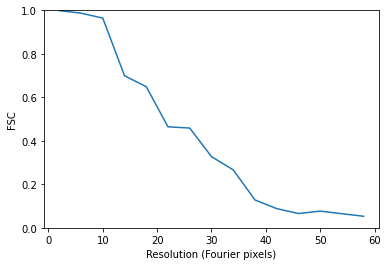

In [24]:
sr = pd.Series(fsc.real)
sr.index = shell_rads
sr[:15].plot()
plt.xlabel('Resolution (Fourier pixels)')
plt.ylabel('FSC')
plt.ylim([0,1])

Which FSC curve does this resemble? How exactly does masking change this computation? What are we masking out? When should we apply the mask?

## with masking
Let's apply a mask and redo this computation

In [25]:
mask  = load_mrc('cryosparc_P9_J209_005_volume_mask_refine.mrc', only_map=True)

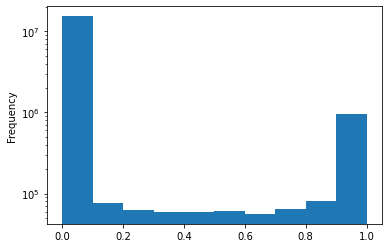

In [26]:
pd.Series(mask.flatten()).plot.hist(logy=True)

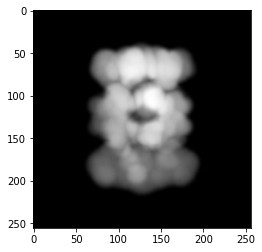

In [27]:
doplt(mask.sum(-1))

This mask is smooth between 0 and 1. Let's multiply it and look at the projection.

Is it cutting out enough of the noisy solvent? Is is cutting too much into the protein. How exactly could we automatically make a mask with code?

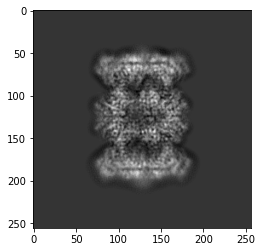

In [28]:
doplt((mask*half_map_A).sum(-1))

In [29]:
half_map_A_masked_f = fourier.do_fft(mask*half_map_A)
half_map_B_masked_f = fourier.do_fft(mask*half_map_B)

When we multiplied through element wise in real space, what did we do in Foureir space? (hint: Fourier-slice theorem)



In [30]:
fsc_masked = do_fsc(half_map_A_masked_f,half_map_B_masked_f,shell_rads)

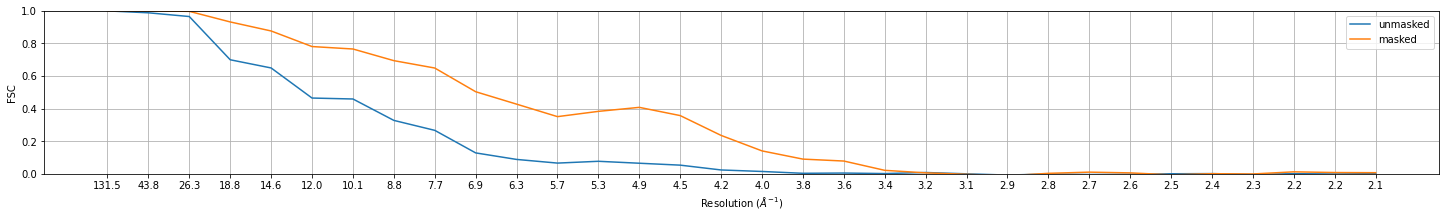

In [55]:
res = shell_rads/(N*psize)
sr = pd.Series(fsc.real)
sr.index = res
sr[:15].plot(legend=True,label='unmasked')

sr = pd.Series(fsc_masked.real)
sr.index = res
sr[:15].plot(legend=True,label='masked')

plt.xlabel(r'Resolution ($\AA^{-1}$)')
plt.ylabel('FSC')

plt.xticks(res,labels=[str(np.round(1/r,1)) for r in res])

plt.ylim([0,1])

plt.rcParams["figure.figsize"] = (25,3)
plt.grid()

Compare this plot to the reported FSC (masked and unmasked).

What effect does masking in this way have on the FSC? How could it be mitigated?

# Sharpening and the FSC
- what happens to the FSC if we sharpen/blur by applying a constant to the rings in Fourier space?


Let's make an "FSC" like curve and use it to blur our map.

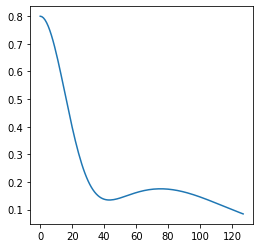

In [68]:
xyz = coords.coords_n_by_d(np.arange(-N//2,N//2),d=3)
atoms = np.zeros(3) 
dist2 = (((xyz - atoms))**2).sum(1)
sigma=64
a = -1/(2*sigma**2)
gauss = np.exp(a*dist2).reshape(N,N,N)

sigma = 16
a2 = -1/(2*sigma**2)
gauss2 = np.exp(a2*dist2).reshape(N,N,N)

sharpen_kernel_gauss = ((gauss.max() - gauss)*gauss*0.7 + 0.8*gauss2)
sharpen_kernel_1d = sharpen_kernel_gauss[N//2,N//2,N//2:]

plt.rcParams["figure.figsize"] = (6,4)
pd.Series(sharpen_kernel_1d).plot()



4.754635530447447e-06

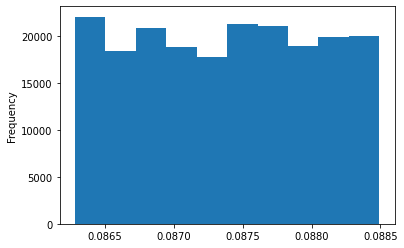

In [69]:
radius = shell_rads[-1]
shell_mask = cmask_3d(index=(N//2,N//2,N//2),radius=radius,array=np.ones_like(map_r), do_shell=True, shell_thickness=1).astype(np.bool)
pd.Series(sharpen_kernel_gauss[shell_mask].flatten()).plot.hist()

np.var(sharpen_kernel_gauss[shell_mask]) / sharpen_kernel_gauss[shell_mask].mean()

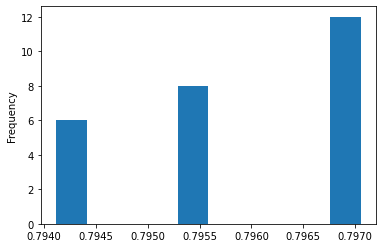

In [70]:
radius = shell_rads[0]
shell_mask = cmask_3d(index=(N//2,N//2,N//2),radius=radius,array=np.ones_like(map_r), do_shell=True, shell_thickness=1).astype(np.bool)
pd.Series(sharpen_kernel_gauss[shell_mask].flatten()).plot.hist()

By construction, our sharpen kernel aplied a multiplicative constant to shells in Fourier space (the same shells that we will use to compute the FSC). Althrough there is some variation in the shells, the values are "close enough" that they are basically a constant. 

In [71]:
half_map_A_sharpened_r = fourier.do_ifft(half_map_A_f*sharpen_kernel_gauss)

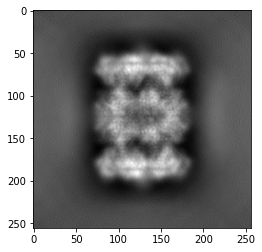

In [72]:
doplt(half_map_A_sharpened_r.sum(-1))

We see the map looks blurred out, compared with the unsharpened map. Here our "sharpening kernel" is actually a blurring kernel. We are "unsharpening".

What do you think happens to the FSC when we sharpen with the same kernel? What does your intuition tell you?

In [73]:
sharpen_kernel = sharpen_kernel_gauss
fsc_sharpened = do_fsc(half_map_A_f*sharpen_kernel,half_map_B_f*sharpen_kernel,shell_rads)

fsc_masked_sharpened = do_fsc(half_map_A_masked_f*sharpen_kernel,half_map_B_masked_f*sharpen_kernel,shell_rads)

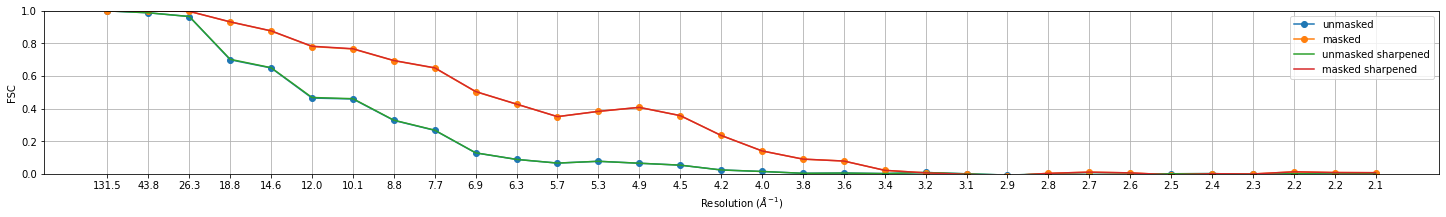

In [75]:
fpix = 30

plt.rcParams["figure.figsize"] = (25,3)


sr = pd.Series(fsc.real)
sr.index = res
sr[:fpix].plot(legend=True,label='unmasked',marker='o')

sr = pd.Series(fsc_masked.real)
sr.index = res
sr[:fpix].plot(legend=True,label='masked',marker='o')

sr = pd.Series(fsc_sharpened.real)
sr.index = res
sr[:fpix].plot(legend=True,label='unmasked sharpened')

sr = pd.Series(fsc_masked_sharpened.real)
sr.index = res
sr[:fpix].plot(legend=True,label='masked sharpened')

plt.xlabel(r'Resolution ($\AA^{-1}$)')
plt.ylabel('FSC')

plt.xticks(res,labels=[str(np.round(1/r,1)) for r in res])

plt.ylim([0,1])

plt.grid()

We see that our new FSCs of our sharpened map completely overlap with our unsharpened maps. This isn't anything special about our maps, and would always be the case because of the equation of the FSC.

If we "sharpen" by multiplying each Fourier shell by the same multiplicative constant, it cancels out, and we get the same FSC as if we hadn't sharpened.

Sharpening changes the human interpitability of the map (helps our eyes notice the overall smooth shape if we blur, or bits of density that might be around the noise level, but corehent in a particular area and agree between half maps).

$$
FSC(cFT[A],cFT[B],shell) 
  = \frac{\sum_{k \in shell}cFT[A]cFT[B]^\dagger}
{
  \sqrt{\sum_{k \in shell}cFT[A]cFT[A]^\dagger}
  \sqrt{\sum_{k \in shell}cFT[B]cFT[B]^\dagger}}
  \\
  = \frac{c^2\sum_{k \in shell}FT[A]FT[B]^\dagger}
{
  \sqrt{c^2\sum_{k \in shell}FT[A]FT[A]^\dagger}
  \sqrt{c^2\sum_{k \in shell}FT[B]FT[B]^\dagger}}
  \\
=\frac{\sum_{k \in shell}FT[A]FT[B]^\dagger}
{
  \sqrt{\sum_{k \in shell}FT[A]FT[A]^\dagger}
  \sqrt{\sum_{k \in shell}FT[B]FT[B]^\dagger}}
  \\
= FSC(FT[A],FT[B],shell) 
$$

### technical aside: centring
a technical aside is that it our sharpening kernel has to be constant in the shell we are using to compute the FSC.

Thankfully the `cmask_3d` function and gaussian function used to make `shapen_kernel` are centred on the same pixel. 

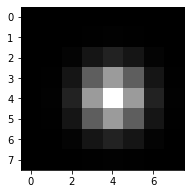

In [77]:
sigma = 1
a2 = -1/(2*sigma**2)
gauss = np.exp(a2*dist2).reshape(N,N,N)

radius = 2
pad = 2
idx_start, idx_end = N//2-radius-pad,N//2+radius+pad
doplt(gauss[idx_start:idx_end, 
            idx_start:idx_end,
            idx_start:idx_end
            ].sum(-1))

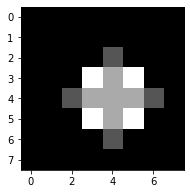

In [78]:

shell_mask = cmask_3d(index=(N//2,N//2,N//2),radius=radius,array=np.ones((N,N,N)), do_shell=True, shell_thickness=1).astype(np.bool)
doplt(shell_mask[idx_start:idx_end, 
            idx_start:idx_end,
            idx_start:idx_end
            ].sum(-1))

If this wasn't exactly the case, and the ofsets were shifted a a pixel or so, we could just make a kernel from the same `cmask_3d` function, and weight it a 1D function, ensuring that the shells overlap does not cause differences (as it does in this case).

In [79]:
sharpen_kernel_3d = np.zeros((N,N,N))
for idx, radius in enumerate(shell_rads):
  sharpen_kernel += sharpen_kernel_1d[radius]*cmask_3d(index=(N//2,N//2,N//2),radius=radius,array=np.ones((N,N,N)), do_shell=True, shell_thickness=1).astype(np.bool)

sharpen_kernel[np.isclose(sharpen_kernel,0)] = 1


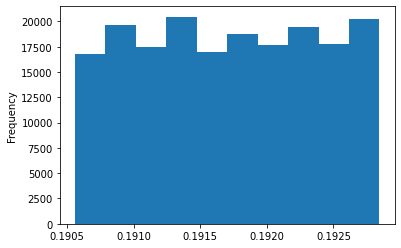

In [85]:
radius = shell_rads[-2]
shell_mask = cmask_3d(index=(N//2,N//2,N//2),radius=radius,array=np.ones_like(map_r), do_shell=True, shell_thickness=1).astype(np.bool)

plt.rcParams["figure.figsize"] = (6,4)
pd.Series(sharpen_kernel[shell_mask]).plot.hist()